In [1]:
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Using inspector let's see what columns are in the table 'measurement'
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# using inspector, let's see what columns are in the table 'station'
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23')

In [12]:
# Find the oldest date in the data set.
oldest_date = session.query(Measurement.date, Measurement.date).order_by(Measurement.date).first()
oldest_date

('2010-01-01', '2010-01-01')

### Design a query to retrieve the last 12 months of precipitation data and plot the results. 

In [13]:
# Starting from the most recent data point in the database, calculate the date one year from the last date in data set.
query_date = dt.date(2017,8 ,23) - dt.timedelta(days=365)
query_date

# Perform a query to retrieve the data with dates and precipitation scores
prcp_query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_query,columns=['date','precipitation']).set_index('date')

# Sort the dataframe by date
prcp_df = prcp_df.sort_index()

#drop NaN values
prcp_df = prcp_df.dropna(how='all')

In [14]:
# There are multiple measurements per day. In order to
#condense the data and the bar graph I will calculate average measurement for each day
grouped_prcp = prcp_df.groupby([prcp_df.index])
grouped_prcp_df = grouped_prcp[['precipitation']].mean()
grouped_prcp_df

,precipitation
date,
2016-08-23,0.451667
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


([<matplotlib.axis.XTick at 0x7fe226be30a0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

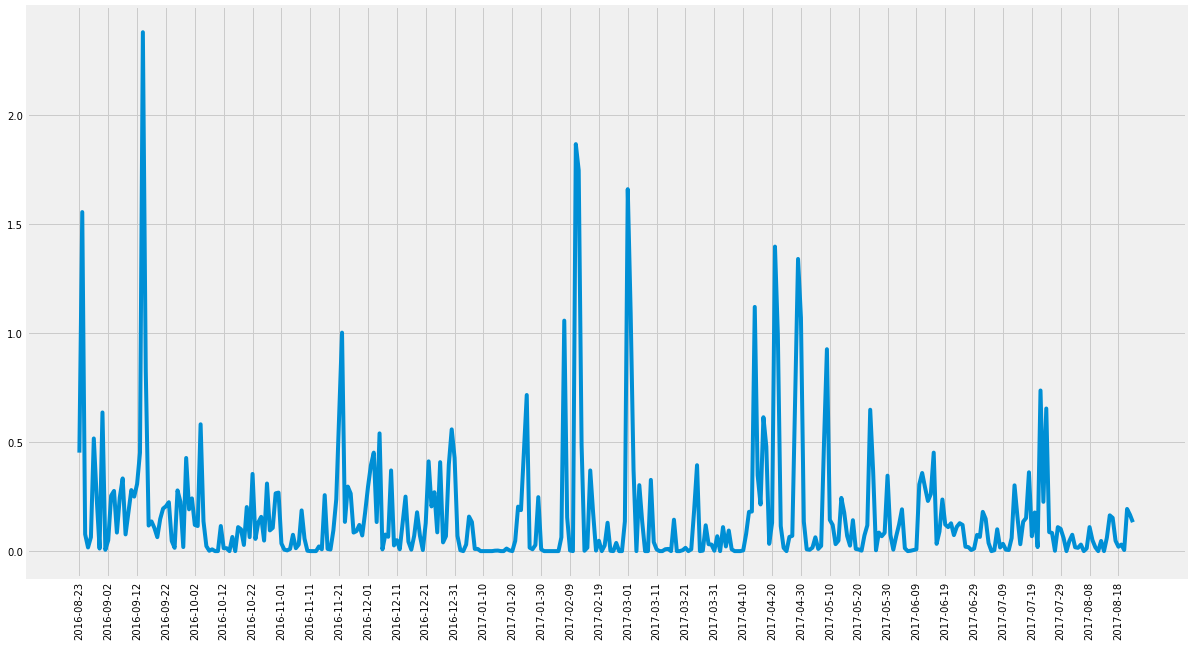

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.plot(grouped_prcp_df.index, grouped_prcp_df['precipitation'])
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
xticks = list(grouped_prcp_df.index)[0::10]
plt.xticks(xticks, rotation='vertical')

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
num_of_stations = session.query(func.count(Station.station)).all()
num_of_stations

[(9)]

In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active_stations =  session.query(Measurement.station, func.count(Measurement.station)).\
                        group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()
most_active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
the_most_active_station = most_active_stations[0][0]
most_active_station_data = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
filter(Measurement.station == the_most_active_station).all()
most_active_station_data

[(54.0, 85.0, 71.66378066378067)]

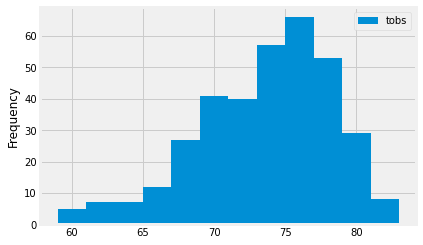

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
the_most_active_station_data =  session.query(Measurement.date,Measurement.tobs).\
                    filter(Measurement.station == the_most_active_station).\
                    filter(Measurement.date >= query_date).all()
the_most_active_station_data_df= pd.DataFrame(the_most_active_station_data).set_index('date')
the_most_active_station_data_df.plot(kind="hist",bins=12);

In [21]:
the_most_active_station_data_df

,tobs
date,
2016-08-23,77.0
2016-08-24,77.0
2016-08-25,80.0
2016-08-26,80.0
2016-08-27,75.0
...,...
2017-08-14,77.0
2017-08-15,77.0
2017-08-16,76.0


# Close session

In [22]:
# Close Session
session.close()